In [1]:
from matplotlib import pyplot as plt
import numpy as np
from numpy import inf
import math
from numpy import pi

In [2]:
# 从脚本中导入数据
from race1 import *

In [3]:
# 保存文件
sen_file = '1km_sen.csv'

In [4]:
# 将数据离散化
dS = 10
S_max = math.floor(S / dS) * dS
num_s = int(S_max / dS) + 1
num_v = 50
num_w = 100
v = np.linspace(v_min, v_max, num_v)
w = np.linspace(0, w_max, num_w)
s = np.linspace(0, S_max, num_s)
len(v), len(w), len(s)

(50, 100, 101)

## 计算theta

In [5]:
# 设置两种赛道的数据，平，斜
import pandas as pd

ramp_theta = 45 * pi / 180

flat_track = np.zeros(num_s)
ramp_track = np.zeros(num_s)

for s_iter in range(num_s):
    ramp_track[s_iter] = ramp_theta

In [6]:
# 设定初始状态
state0 = '0,' + str(num_w - 1)
state0

'0,99'

## 计算功率策略

In [7]:
# 定义4种功率计算的策略
def U_strategy(category, **kwargs):
    """
    Umax(vi, wi)
    Ua0(vi, theta)
    Ucp()
    U0()
    """
    if category == 'Umax':
        return Umax(kwargs['vi'], kwargs['wi'])
    if category == 'Ua0':
        return Ua0(kwargs['vi'], kwargs['wi'], kwargs['theta'])
    if category == 'Ucp':
        return Ucp()
    if category == 'U0':
        return U0()
    assert 0

# Umax
def Umax(vi, wi):
    coef = 0.04
    # return (0.8 * wi + CP) * (vi / (30 + coef * wi) ) * (1 - vi / (30 + coef * wi)) * 3.2
    return 7e-6 * wi**2 + 0.0023 * wi + CP

# Ua=0
def Ua0(vi, wi, theta):
    # return (gravity * (math.sin(theta) + mu * math.cos(theta)) + 0.5 * Cd * rho * A * vi**2 / mass) * mass * vi
    res = (0.12 * gravity * (math.sin(theta) + mu * math.cos(theta)) + 0.03 * vi**2 / mass) * mass * vi
    return min(res, Umax(vi, wi))

def Ucp():
    return CP

def U0():
    return 0

In [8]:
# 10m/s时U = 600, a = 0
v10 = 10
# gravity * (math.sin(0) + mu * math.cos(0)) + arg * v10**2 / mass ==  Umax(0, w_max) / (mass * v10)
arg = (Umax(0, w_max) / (mass * v10) - gravity * (math.sin(0) + mu * math.cos(0))) * mass / (v10**2)
arg

-1.7693454929999999

In [9]:
wi = 600
vi = 10
Umax(vi, wi), Ua0(vi, wi, 0.02)

(208.5, 208.5)

In [10]:
# 最大的Umax
vi = 16
Umax(vi, CP), Umax(vi, w_max)

(205.36360811999998, 620.874507)

In [11]:
def get_nearest(val, arr):
    """在arr中找到和val最接近的值的下标"""
    arr = np.array(arr)
    sub = abs(arr - val)
    ind = np.argmin(sub)
    return ind

arr = [1, 2, 3, 4, 5]
val = 3.8
arr[get_nearest(val, arr)]

4

In [12]:
def get_vw(key):
    """根据字典键值返回v,w"""
    v_ind, w_ind = key.split(',')
    return v[int(v_ind)], w[int(w_ind)]

## 计算下一个速度

In [13]:
def cal_v_next(vi, ui, theta):
    """计算下一个时间的速度"""
    # res = vi + dS / vi * (ui / (mass * vi) - gravity * (math.sin(theta) + mu * math.cos(theta)) - 0.5 * Cd * rho * A * vi**2 / mass + 0.3 * g_vw**2 * math.cos(g_w_theta))
    # a = 1.5* ui / (mass * vi) - gravity * (math.sin(theta) + mu * math.cos(theta)) -1.67 * vi**2 / mass
    # print(a)
    # res = vi + 0.1 * dS / vi * a
    res = (0.0008 * ui + 0.5154) * (-0.0058 * vi**2 + 0.9526 * vi + 1.5625) - 0.1 * gravity * (math.sin(theta) + mu * math.cos(theta))
    return res + 2
    

In [14]:
t = np.pi * 5 / 180

gravity * (math.sin(t) + mu * math.cos(t))

3.7829386913167826

In [15]:
0.5 * Cd * rho * A

0.09675

In [16]:
# 计算：10m/s时，受力达到平衡
v10 = 10
# Umax(0, w_max) / (mass * v10) == gravity * (math.sin(0) + mu * math.cos(0)) - arg * v10**2 / mass
arg = -(gravity * (math.sin(0) + mu * math.cos(0)) + Umax(0, w_max) / (mass * v10)) * mass / v10**2
arg

-3.0110945069999997

In [17]:
cal_v_next(3, 700, 0)

6.403454740000001

## 计算下一个W

In [18]:
def cal_w_next(vi, wi, ui):
    """计算下一个时间的无氧功"""
    if ui >= CP:
        return wi + dS / vi * (CP - ui)
    else:
        a = 0.11
        b = 237.5
        return wi + dS / vi * (CP - a * ui - b)

In [19]:
def clamp(val, limit1, limit2):
    if limit1 < limit2:
        minV, maxV = limit1, limit2
    else:
        minV, maxV = limit2, limit1
    
    if val < minV:
        return minV
    elif val > maxV:
        return maxV
    else:
        return val


In [20]:
S

1000

## 计算所有转移状态

In [21]:
# categories = ['Umax', 'Ucp', 'U0']
categories = ['Umax', 'Ua0', 'Ucp', 'U0']

In [22]:
def cal_next_state():
    # next_state[s_ind]['v_ind,w_ind']代表当前的s对应的行状态为(v, w)的下一个状态的v', w'
    # next_state长度为num_s, 最后一个（S_max）没有值（即下一个状态），只有键（即当前状态）
    next_state = []
    for i in range(num_s):
        next_state.append({})

    # 初始化v和w
    next_state[0][state0] = []

    # 为next_state生成所有可能的状态
    for s_iter in range(num_s - 1):
        for cur_st in next_state[s_iter].keys():
            # 生成4种全新的状态
            v_cur, w_cur = get_vw(cur_st)
            # 计算v_next, w_next
            args = [{'vi':v_cur, 'wi':w_cur}, {'vi':v_cur, 'wi':w_cur, 'theta':theta[s_iter]}, {}, {}]
            # args = [{'vi':v_cur, 'wi':w_cur}, {}, {}]
            for cat, arg in zip(categories, args):
                u_cur = U_strategy(cat, **arg)
                v_next = cal_v_next(v_cur, u_cur, theta[s_iter])
                w_next = cal_w_next(v_cur, w_cur, u_cur)

                v_next_ind = get_nearest(v_next, v)
                w_next_ind = get_nearest(w_next, w)
                # 添加到下一层的next_state
                k = ','.join([str(v_next_ind), str(w_next_ind)])
                
                next_state[s_iter][cur_st].append(k)
                if k not in next_state[s_iter + 1].keys():
                    next_state[s_iter + 1][k] = []

    return next_state

## 后向DP

In [23]:
def backward_DP(next_state):
    # 动态规划方法2
    J = []
    for i in range(num_s):
        J.append({})

    # 初始化终点的值
    for key in next_state[num_s - 1].keys():
        J[num_s - 1][key] = 0

    # 记录每个状态选择的模式，最后一个状态不选择
    best_modes = []
    for i in range(num_s - 1):
        best_modes.append({})

    for s_iter in range(num_s - 2, -1, -1): 
        for cur_st, next_stats in next_state[s_iter].items():
            # 获得当前的状态
            v_cur, w_cur = get_vw(cur_st)
            # 当前状态转移得到的4种新状态中时间最短的
            cost_min = inf
            best_mod = 0
            # 对于每一个转移后的状态，计算所用的时间
            for mode_ind, next_st in enumerate(next_stats):
                v_next, w_next = get_vw(next_st)
                # 计算dS路程内花费的平均时间
                dt = dS / (v_cur + v_next)
                cost = dt
                # if next_st in J[s_iter + 1].keys():
                Ji = J[s_iter + 1][next_st]
                cost += Ji

                if cost < cost_min:
                    cost_min = cost
                    best_mod = mode_ind
            
            J[s_iter][cur_st] = cost_min
            best_modes[s_iter][cur_st] = best_mod
    return best_modes

In [24]:
def choose_best(next_state, best_modes):
    # 通过每个状态选择的模式推导出最优状态及其功率
    cur_st = state0

    v0, w0 = get_vw(state0)
    # 统计v
    v_best = [v0]

    # 统计w
    w_best = [w0]

    # 统计u
    u_best = []

    # 统计mode
    mode_best = []
    # categories = ['Umax', 'Ua0', 'Ucp', 'U0']

    for s_iter in range(num_s - 1):
        mode_ind = best_modes[s_iter][cur_st]
        mode_best.append(mode_ind)
        # 得到下一个状态
        next_st = next_state[s_iter][cur_st][mode_ind]
        v_next, w_next = get_vw(next_st)
        v_best.append(v_next)
        w_best.append(w_next)

        args = [{'vi':v_next, 'wi':w_next}, {'vi':v_next, 'wi':w_next, 'theta':theta[s_iter]}, {}, {}]
        # args = [{'vi':v_next, 'wi':w_next}, {}, {}]
        u_next = U_strategy(categories[mode_ind], **args[mode_ind])
        u_best.append(u_next)
        cur_st = next_st

    return v_best, w_best, u_best, mode_best


## 根据速度计算的时间

In [25]:
def cal_best_time(v_best):
    sum_t = 0
    for vi in v_best:
        sum_t += dS / vi
    return sum_t

In [26]:
# 根据上一个速度和当前的u计算下一个速度，获得所有速度，然后计算最短时间
def cal_time_with_u(u_list, v0, track):
    v_list = np.zeros(num_s)
    v_list[0] = v0
    for s_iter in range(1, num_s):
        vi = v_list[s_iter - 1]
        ui = u_list[s_iter - 1]
        v_next = cal_v_next(vi, ui, track[s_iter])
        v_list[s_iter] = v_next

    cur_time = cal_best_time(v_list)
    return cur_time, v_list

## 算法流水线

In [27]:
rates = [1, 0.9, 0.8, 0.7, 0.6]

In [28]:
# 分别计算出在平地和陡坡曲线下的最优u
# 平地
theta = flat_track
next_state = cal_next_state()
best_modes = backward_DP(next_state)
v_best, w_best, u_best, mode_best = choose_best(next_state, best_modes)

u_best = np.array(u_best)
time_flats = np.zeros(len(rates))

for r_iter, rate in enumerate(rates):
    time_flats[r_iter], _ = cal_time_with_u(u_best * rate, v_min, theta)

# 分别设置0.8, 0.6 * u，计算时间
# time_flat8, _ = cal_time_with_u(u_best * 0.8, v_min, theta)
# time_flat6, _ = cal_time_with_u(u_best * 0.6, v_min, theta)



In [29]:
time_flats

array([123.95653982, 131.38854208, 139.1312962 , 147.18460373,
       155.54949519])

<BarContainer object of 5 artists>

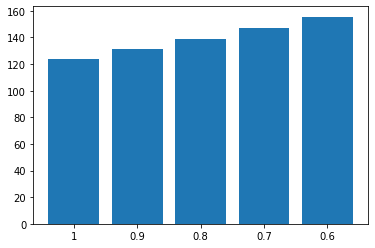

In [30]:
plt.bar([str(rate) for rate in rates], time_flats)

In [31]:
# 斜坡
theta = ramp_track
next_state = cal_next_state()
best_modes = backward_DP(next_state)
v_best, w_best, u_best, mode_best = choose_best(next_state, best_modes)

u_best = np.array(u_best)
time_ramps = np.zeros(len(rates))

for r_iter, rate in enumerate(rates):
    time_ramps[r_iter], _ = cal_time_with_u(u_best * rate, v_min, theta)
# 分别设置0.8, 0.6 * u，计算时间
# time_ramp8, _ = cal_time_with_u(u_best * 0.8, v_min, theta)
# time_ramp6, _ = cal_time_with_u(u_best * 0.6, v_min, theta)

<BarContainer object of 5 artists>

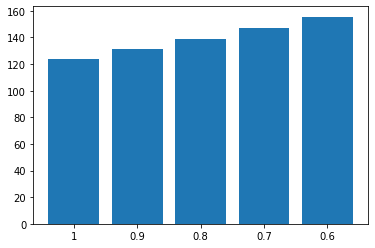

In [32]:
plt.bar([str(rate) for rate in rates], time_flats)

## 数据保存


In [33]:
len(cat), len(u_sen), len(t_sen)

NameError: name 'cat' is not defined

In [ ]:
cat = ['flat'] * len(rates) + ['ramp'] * len(rates)
u_sen = rates[:] * 2
t_sen = list(time_flats) + list(time_ramps)

data = pd.DataFrame({'categories':cat, 'U':u_sen, 'time':t_sen})
data

,categories,U,time
0,flat,1.0,102.598090
1,flat,0.9,111.224665
2,flat,0.8,120.381585
3,flat,0.7,130.060971
4,flat,0.6,140.258024
5,ramp,1.0,120.781089
6,ramp,0.9,131.198981
7,ramp,0.8,142.301240
8,ramp,0.7,154.086877
9,ramp,0.6,166.558650


In [ ]:
data_time = data['time']
data_increase = np.zeros(data.shape[0])
d_iter = 0
while d_iter < data.shape[0]:
    for i in range(len(rates)):
        if i == 0:
            data_increase[d_iter] = 0
        else:
            data_increase[d_iter + i] = ((data_time[d_iter + i]) - data_time[d_iter]) / data_time[d_iter]
    d_iter += len(rates)


# data_increase[0] = 0
# data_increase[1] = (data_time[1] - data_time[0]) / data_time[0]
# data_increase[2] = (data_time[2] - data_time[0]) / data_time[0]

# data_increase[3] = 0
# data_increase[4] = (data_time[4] - data_time[3]) / data_time[3]
# data_increase[5] = (data_time[5] - data_time[3]) / data_time[3]

data['increase'] = data_increase
data

,categories,U,time,increase
0,flat,1.0,102.598090,0.000000
1,flat,0.9,111.224665,0.084081
2,flat,0.8,120.381585,0.173332
3,flat,0.7,130.060971,0.267674
4,flat,0.6,140.258024,0.367063
5,ramp,1.0,120.781089,0.000000
6,ramp,0.9,131.198981,0.086254
7,ramp,0.8,142.301240,0.178175
8,ramp,0.7,154.086877,0.275753
9,ramp,0.6,166.558650,0.379013


In [ ]:
data.to_csv(sen_file)

In [ ]:
Umax_best = []
for vi, wi in zip(v_best, w_best):
    Umax_best.append(Umax(vi, wi))

In [ ]:
len(v_best), len(w_best), len(u_best), len(Umax_best), len(mode_best)

(101, 101, 100, 101, 100)

In [ ]:
save_data = pd.DataFrame({'distance':s, 'speed':v_best, 'w':w_best, 'u':[u_best[0]] + u_best, 'Umax':Umax_best, 'Umode':[mode_best[0]] + mode_best})
save_data.shape

ValueError: arrays must all be same length

In [ ]:
save_data.head()

,distance,speed,w,u,Umax,Umode
0,0.0,3.000000,7841.0,269.0,717.403267,2
1,10.0,4.734694,7841.0,269.0,717.403267,2
2,20.0,5.775510,7841.0,269.0,717.403267,2
3,30.0,6.469388,7841.0,269.0,717.403267,2
4,40.0,7.163265,7841.0,269.0,717.403267,2


In [ ]:
save_data['Umode'].value_counts()

0    92
2     7
1     2
Name: Umode, dtype: int64

In [ ]:
# save_data.to_csv(save_file)

## 速度图

Text(0.5, 1.0, 'Speed Curve')

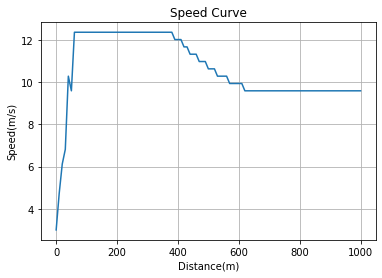

In [ ]:
plt.plot(s, v_best)
plt.grid(True)
plt.box(True)
plt.xlabel('Distance(m)')
plt.ylabel('Speed(m/s)')
plt.title('Speed Curve')



In [ ]:
def fill_li(li, interval):
    if type(li) == list:
        li_fill = li + [0] * (math.ceil(len(li) / interval) * interval - len(li))
    else:
        li_fill = li[:]
    return np.reshape(li_fill, (-1, interval))

In [ ]:
interval = 40

In [ ]:
v_best_fill = fill_li(v_best, interval)

In [ ]:
v_best_fill.shape

(3, 40)

In [ ]:
mean_v_best = v_best_fill.mean(axis=1)
mean_v_best[0:5]

array([11.51734694, 10.24234694,  5.03571429])

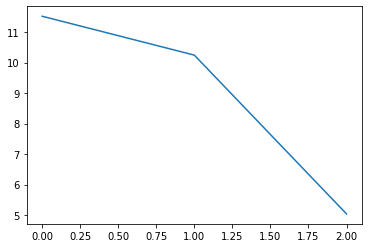

In [ ]:
plt.plot(mean_v_best);

In [ ]:
pd.Series(v_best).value_counts()

9.591837     40
12.367347    33
9.938776      5
10.285714     5
11.326531     3
12.020408     3
10.979592     3
10.632653     3
11.673469     2
6.816327      1
4.734694      1
6.122449      1
3.000000      1
dtype: int64

## W图

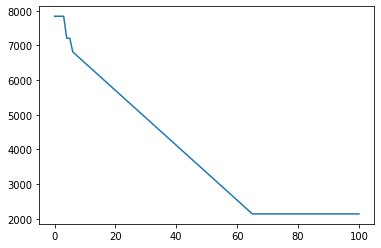

In [ ]:
plt.plot(w_best)

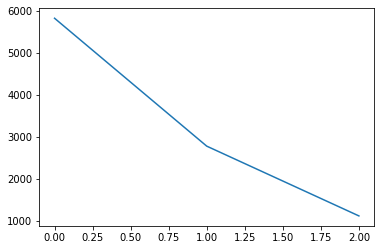

In [ ]:
w_best_fill = fill_li(w_best, interval)
mean_w_best = w_best_fill.mean(axis=1)
plt.plot(mean_w_best)

## U图

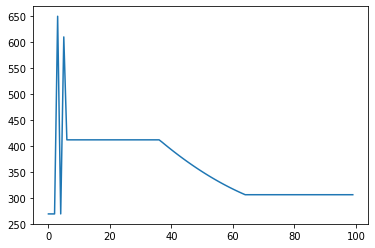

In [ ]:
plt.plot(u_best)

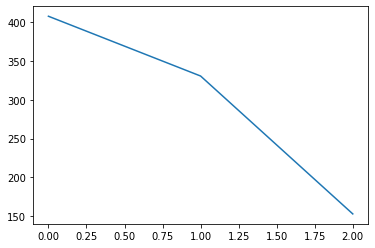

In [ ]:
u_best_fill = fill_li(u_best, interval)
mean_u_best = u_best_fill.mean(axis=1)
plt.plot(mean_u_best)

## Umax图

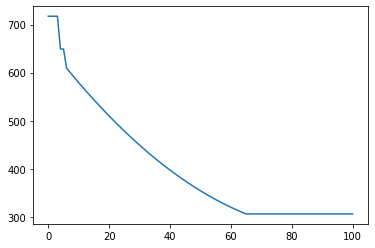

In [ ]:
plt.plot(Umax_best)

## Mode图

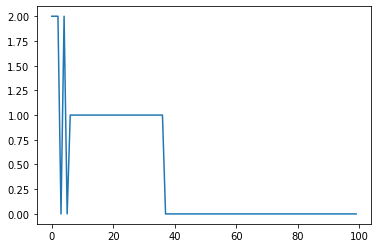

In [ ]:
plt.plot(mode_best)

In [ ]:
mode_interval = 10
mode_best_fill = fill_li(mode_best, mode_interval)
mode_best_fill.shape

(10, 10)

In [ ]:
mode_best_fill[:5,:]

array([[2, 2, 2, 0, 2, 0, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
pd.Series(mode_best_fill[0,:].flat).value_counts().sort_values()

0    2
2    4
1    4
dtype: int64

In [ ]:
# 获取数组中数量最多的值
pd.Series(mode_best_fill[4,:].flat).value_counts().sort_values().index.values[-1]

0

In [ ]:
# 统计interval中最多mode的数目
cnt_mode_best = np.zeros(mode_best_fill.shape[0])
for row_iter in range(mode_best_fill.shape[0]):
    cnt_mode_best[row_iter] = pd.Series(mode_best_fill[row_iter,:].flat).value_counts().sort_values().index.values[-1]

In [ ]:
cnt_mode_best.shape

(10,)

In [ ]:
cnt_mode_best[0:8]

array([1., 1., 1., 1., 0., 0., 0., 0.])

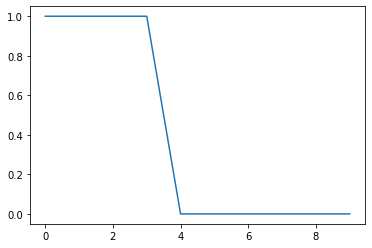

In [ ]:
plt.plot(cnt_mode_best)

In [ ]:
mode_best[0:10]

[2, 2, 2, 0, 2, 0, 1, 1, 1, 1]

In [ ]:
pd.Series(mode_best).value_counts()

0    65
1    31
2     4
dtype: int64

In [ ]:
v_best[0:10]

[3.0,
 4.73469387755102,
 6.122448979591837,
 6.816326530612245,
 10.285714285714285,
 9.591836734693878,
 12.36734693877551,
 12.36734693877551,
 12.36734693877551,
 12.36734693877551]

In [ ]:
u_best[:10]

[269,
 269,
 269,
 649.2016553848588,
 269,
 609.4298449272524,
 411.4762027372948,
 411.4762027372948,
 411.4762027372948,
 411.4762027372948]

In [ ]:
w_best[-1]

2138.4545454545455

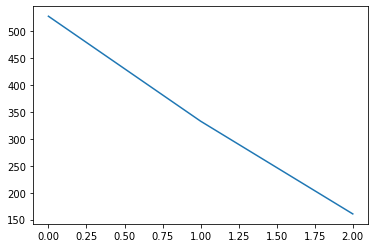

In [ ]:
Umax_best_fill = fill_li(Umax_best, interval)
mean_Umax_best = Umax_best_fill.mean(axis=1)
plt.plot(mean_Umax_best)

In [ ]:
data['AltitudeMeters'].plot()

NameError: name 'data' is not defined

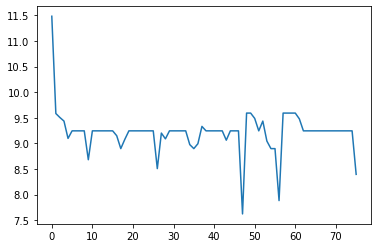

In [ ]:
plt.plot(mean_v_best)